## Install needed Libraries

### Install Libraries from pip

In [587]:
!pip install langchain langchain-community pandas numpy matplotlib seaborn nltk textstat

   ---------------------------------------- 0.0/939.4 kB ? eta -:--:--
   --------------------------------------- 939.4/939.4 kB 10.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 16.5 MB/s eta 0:00:00


### Import needed Libraries

In [589]:
import pandas as pd
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Download the needed nltk corpus 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import textstat
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soyel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soyel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Convert Excel Spreadsheet to pandas Data Frame

In [591]:
# Read Excel containig List of URL's with Architectural Pattern and Metadata.
url_df = pd.read_excel("./URLs.xlsx", sheet_name="Sheet1")
# Show shape of DataFrame
print("Shape: ",url_df.shape)
# Show the Format of the Data Frame
url_df.head()

Shape:  (213, 6)


,URL,1st Level,2nd Level,3rd Level,4th Level,Lens
0,https://docs.aws.amazon.com/wellarchitected/la...,Abstract and Introducción,NaN,NaN,NaN,Serverless Applications
1,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,NaN,NaN,NaN,Serverless Applications
2,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Compute Layers,NaN,NaN,Serverless Applications
3,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Data Layer,NaN,NaN,Serverless Applications
4,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Messaging and streaming layer,NaN,NaN,Serverless Applications


The data frame shows multiple links where the data is stored. The number of links can be seen in the data frame's shape; we have a total of X links.

To obtain additional metadata for each link, we created a structure that includes the name of the AWS Well-Architected Lens in the "Lens" column, and its subsections in the "1st Level," "2nd Level," "3rd Level," and "4th Level" columns. If a link points to information at an upper level, the lower-level columns will display NaN.

## Read each link and store the Data in correct Format

### Create Function to add Level to metadata

In [597]:
# We create a function to validate if a level exist in a row of the dataframe
def createMetadataLevel(level,url_line,metadata):
    #Validate if the Level is enot empty
    if(not pd.isna(url_line[level])):
        #If level is not empty add the level to the metadata
        metadata[level]=url_line[level]
    #Return the modified metadata.
    return metadata

### Create function to load the URL with the extra metadata.

In [600]:
def loadURLWithMetaData(url_line):
    # We define the loader, which will read the information in the URL's leveraging the langchain library.
    loader = WebBaseLoader(
        # We say, which URL will be read and loaded.
        url_line["URL"],
    )
    # We will read the URL and get different documents from all the paragraphs.
    docs = loader.load()
    # We define all the metadata to add to the docs read from this page
    metadata = {
        "Lens": url_line["Lens"],
        "1st Level": url_line["1st Level"]
    }
    # Add all levels of metadata, validating the level exists.
    metadata = createMetadataLevel("2nd Level",url_line,metadata)
    metadata = createMetadataLevel("3rd Level",url_line,metadata)
    metadata = createMetadataLevel("4th Level",url_line,metadata)

    for doc in docs:
        doc.metadata.update(metadata)

    return docs
        
    

### Cycle trough all URL's in the list and load them

In [603]:
#Define Variable to store all information extracted from the URL's with the metadata.
all_docs = []
#Cycle trough all URL's to load them as text and add the desired metadata.
for index, row in url_df.iterrows():
    #Read the content of the URL, add it to the list with it's needed metadata in the propper format, to be able to process it later.
    all_docs.extend(loadURLWithMetaData(row))
print("This is a sample of the content extracted from the URL's", all_docs[0])

This is a sample of the content extracted from the URL's page_content='
Serverless Applications Lens - AWS Well-Architected Framework - Serverless Applications LensServerless Applications Lens - AWS Well-Architected Framework - Serverless Applications LensDocumentationAWS Well-ArchitectedAWS Well-Architected FrameworkIntroductionCustom lens availabilityServerless Applications Lens - AWS Well-Architected FrameworkPublication date: July 14, 2022 (Document revisions)
    This document describes the Serverless Applications Lens for
    the AWS
      Well-Architected Framework. The document covers common
    serverless applications scenarios and identifies key elements to
    ensure that your workloads are architected according to best
    practices.
  
Introduction

      The AWS Well-Architected Framework helps you understand the pros and
      cons of decisions you make while building systems on AWS. By using
      the Framework, you will learn architectural best practices for
      desi

## Convert docs into data frame to perform some discoveries

In [605]:
#Define Function to convert documents into dataframe
def create_dataframe_from_documents(documents):
    # declare variable to store the data
    data = []
    # declare variable to store the metadata
    for doc in documents:
        # define the row as a dictionary from the content
        row = {"page_content": doc.page_content}
        # Add the metadata to the row
        row.update(doc.metadata)
        # Add the row to the list of data
        data.append(row)
    # Return the data frame of all docs
    return pd.DataFrame(data)

### Call function to convert all documents to a dataframe

In [607]:
df_from_docs = create_dataframe_from_documents(all_docs)

## EDA

### Review dataframe general data

#### Review 5 first values of data frame

In [611]:
df_from_docs.head()

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
0,\nServerless Applications Lens - AWS Well-Arch...,https://docs.aws.amazon.com/wellarchitected/la...,Serverless Applications Lens - AWS Well-Archit...,This document describes the Serverless Applica...,en-US,Serverless Applications,Abstract and Introducción,NaN,NaN,NaN
1,\nDefinitions - Serverless Applications LensDe...,https://docs.aws.amazon.com/wellarchitected/la...,Definitions - Serverless Applications Lens,The AWS Well-Architected Framework is based on...,en-US,Serverless Applications,Definitions,NaN,NaN,NaN
2,\nCompute layer - Serverless Applications Lens...,https://docs.aws.amazon.com/wellarchitected/la...,Compute layer - Serverless Applications Lens,The compute layer of your workload manages req...,en-US,Serverless Applications,Definitions,Compute Layers,NaN,NaN
3,\nData layer - Serverless Applications LensDat...,https://docs.aws.amazon.com/wellarchitected/la...,Data layer - Serverless Applications Lens,The data layer of your workload manages persis...,en-US,Serverless Applications,Definitions,Data Layer,NaN,NaN
4,\nMessaging and streaming layer - Serverless A...,https://docs.aws.amazon.com/wellarchitected/la...,Messaging and streaming layer - Serverless App...,The messaging layer of your workload manages c...,en-US,Serverless Applications,Definitions,Messaging and streaming layer,NaN,NaN


#### Review last 5 Values of the data frame

In [613]:
df_from_docs.tail()

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
208,\nConclusion - Financial Services Industry Len...,https://docs.aws.amazon.com/wellarchitected/la...,Conclusion - Financial Services Industry Lens,Conclusion,en-US,Financial Services Industry,Conclusion,NaN,NaN,NaN
209,\nContributors - Financial Services Industry L...,https://docs.aws.amazon.com/wellarchitected/la...,Contributors - Financial Services Industry Lens,Contributors,en-US,Financial Services Industry,Contributors,NaN,NaN,NaN
210,\nDocument revisions - Financial Services Indu...,https://docs.aws.amazon.com/wellarchitected/la...,Document revisions - Financial Services Indust...,Document revisions,en-US,Financial Services Industry,Document revisions,NaN,NaN,NaN
211,\nNotices - Financial Services Industry LensNo...,https://docs.aws.amazon.com/wellarchitected/la...,Notices - Financial Services Industry Lens,Notices,en-US,Financial Services Industry,Notices,NaN,NaN,NaN
212,\nAWS Glossary - Financial Services Industry L...,https://docs.aws.amazon.com/wellarchitected/la...,AWS Glossary - Financial Services Industry Lens,Lists the latest AWS terminology and usage.,en-US,Financial Services Industry,AWS Glossary,NaN,NaN,NaN


#### List all the Columns of the Data Frame

In [615]:
df_from_docs.columns

Index(['page_content', 'source', 'title', 'description', 'language', 'Lens',
       '1st Level', '2nd Level', '3rd Level', '4th Level'],
      dtype='object')

#### List general info about the DataFrame

In [617]:
df_from_docs.info

<bound method DataFrame.info of                                           page_content  \
0    \nServerless Applications Lens - AWS Well-Arch...   
1    \nDefinitions - Serverless Applications LensDe...   
2    \nCompute layer - Serverless Applications Lens...   
3    \nData layer - Serverless Applications LensDat...   
4    \nMessaging and streaming layer - Serverless A...   
..                                                 ...   
208  \nConclusion - Financial Services Industry Len...   
209  \nContributors - Financial Services Industry L...   
210  \nDocument revisions - Financial Services Indu...   
211  \nNotices - Financial Services Industry LensNo...   
212  \nAWS Glossary - Financial Services Industry L...   

                                                source  \
0    https://docs.aws.amazon.com/wellarchitected/la...   
1    https://docs.aws.amazon.com/wellarchitected/la...   
2    https://docs.aws.amazon.com/wellarchitected/la...   
3    https://docs.aws.amazon.com/wellar

#### General info, including total Count (Null Values)

In [619]:
df_from_docs.describe(include='all')

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
count,213,213,213,210,213,213,213,188,120,20
unique,213,213,194,200,1,2,17,59,93,17
top,\nServerless Applications Lens - AWS Well-Arch...,https://docs.aws.amazon.com/wellarchitected/la...,Key AWS services - Financial Services Industry...,Resources,en-US,Financial Services Industry,The pillars of the Well-Architected Framework,Performance efficiency pillar,Operate,AWS Lambda
freq,1,1,6,4,213,131,58,14,8,2


With all this information we can confirm the data was extracted succesfully from the different URL's and we can see that the metadata was appended succesfully, we see multipple missing values as expected that will show the relationship between documents and we can confirm all URL's have a parent topic and a Lens seeing no Null values on the COlumn Lens and Column 1st Level.

### Analyzing Text Content

#### Text Length

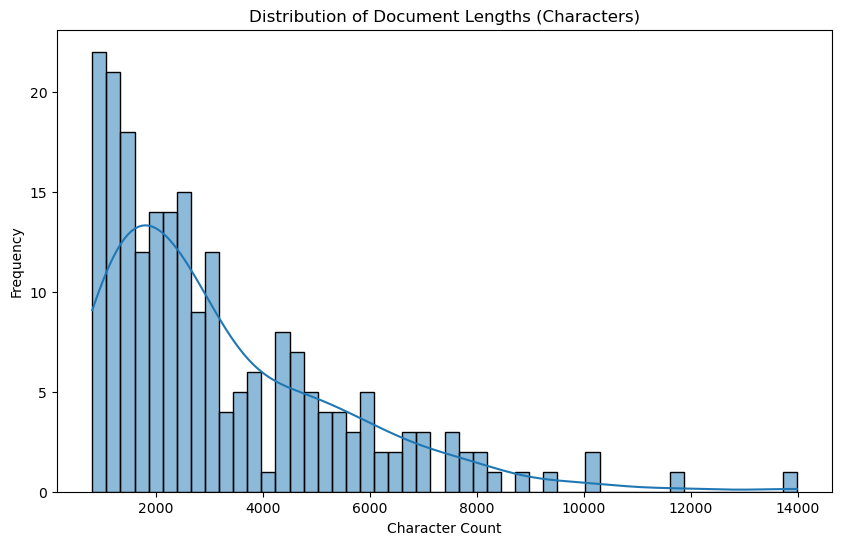

In [623]:
# Adding a column to the dataframe that contains the length of each sentence.
df_from_docs['content_length'] = df_from_docs['page_content'].apply(len)
#Define size of the plot to make
plt.figure(figsize=(10, 6))
# Create Histogram showing the length of the sentences
sns.histplot(df_from_docs['content_length'], bins=50, kde=True)
# Add title to the Histogram
plt.title('Distribution of Document Lengths (Characters)')
# Add title to the X axis
plt.xlabel('Character Count')
# Add title to the u axis
plt.ylabel('Frequency')
# Show histogram
plt.show()

By reviewing the form of the Graph we can see that the distribution is skewed, which means we have very long text and very short text, however we see that the mayority of the text have a lower amount of words in arround 200 words, this will help us to define the chunk size for the next phase, when we do preprocesing to the data.

#### Vocabulary Analysis

##### Define function to get top N words

In [627]:
# Declare the stopwords, so we can ignore the ost common words in english vocabulary that do not add much sense to the senteces
stop_words = set(stopwords.words('english'))
stop_words.add("aws")
stop_words.add("amazon")
stop_words.add("us")
#Define the fucntion to generate the top N words
def get_top_n_words(docs, n=20):
    # Tokenize the words in the corpus
    word_tokens = [word.lower() for doc in docs for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words]
    # Count the times a word appears
    word_counts = Counter(word_tokens)
    # Return the Top n words
    return word_counts.most_common(n)

##### Get the 20 most common words

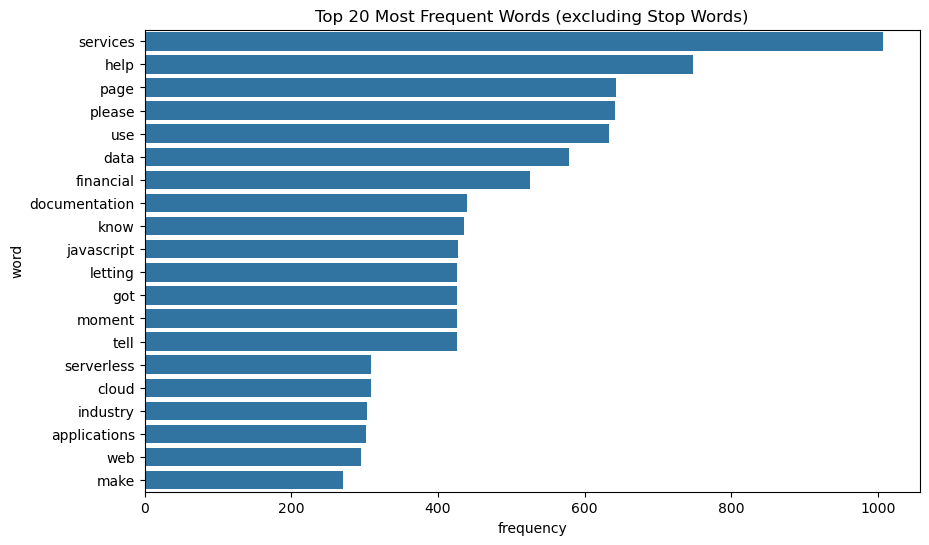

In [629]:
# Get the top words from all the documents
top_words = get_top_n_words(df_from_docs['page_content'])
# Create a new dataframe containing the word and the frquency of each word
df_top_words = pd.DataFrame(top_words, columns=['word', 'frequency'])
# Define plot size
plt.figure(figsize=(10, 6))
# Create Bar Plot to show the Most common words in a graph
sns.barplot(x='frequency', y='word', data=df_top_words)
# Add title to the graph
plt.title('Top 20 Most Frequent Words (excluding Stop Words)')
# SHow the graph
plt.show()

From here we can see that the most common word is services appearing ove 1000 time, this makes sense as the architectural patterns try to recomend services that you can use based on the requirements so this shows the data has relavant information we can use for our Use case.

#### Readability

##### Define function to get redability scores

In [692]:
#define Function to calculate readability
def calculate_readability(text):
    try:
        #Define the scores to calculate from the received text
        scores = {
            "flesch_reading_ease": textstat.flesch_reading_ease(text),
            "smog_grade": textstat.smog_index(text),
        }
        # Return the value of the scores
        return scores
    # Throw exception when there is an error
    except Exception as e:
        # #Return the error value
        return {"error": str(e)}


##### Calculate ease of reading metrics

In [695]:
# Add a new column to the data frame with all the redability metrics per document
df_from_docs['readability_scores'] = df_from_docs['page_content'].apply(calculate_readability)
# Create a new dataframe containing only the readability metrics in separete columns
readability_df = pd.json_normalize(df_from_docs['readability_scores'])
# Add the metrics in separete columns to the original data frame
df_from_docs = pd.concat([df_from_docs, readability_df], axis=1).drop(columns=['readability_scores'])
# print the metrics
print("Readability Scores (using textstat):")
print(df_from_docs.describe())

Readability Scores (using textstat):
       content_length  flesch_reading_ease  smog_grade  flesch_kincaid_grade  \
count      213.000000           213.000000  213.000000            213.000000   
mean      3212.178404            32.600094   14.473709             12.794366   
std       2280.335015            10.428330    2.082670              2.386136   
min        808.000000           -32.380000   10.800000              8.600000   
25%       1504.000000            27.010000   13.300000             11.300000   
50%       2478.000000            33.040000   14.200000             12.600000   
75%       4405.000000            39.740000   15.600000             13.900000   
max      13976.000000            52.360000   30.700000             30.800000   

       coleman_liau_index  dale_chall_readability_score  flesch_reading_ease  \
count          213.000000                    213.000000           213.000000   
mean            15.745211                      9.014883            32.600094   
st

We see in general the text is relative complex to understand and this alligns with the expectations the flesh_reading ease of 32 in average tells us that the text are intended to be read by a college studemt or above. So this makes sense as the data is very technical so we are expecting the inputs to be very technical as well, this is something to consider when creating prompts as if the prompts are very simple this might cause an issue, this might need to us to be sure the metadat is helpfull enough to pull the right information. We can confirm this with a smog_grade of 13, that alligns with the level of education expected to understaand the text. 
As this model is going to be utilized by profesionals in IT it is expected they will be able to provide the complex enoughh queries.

ESTE ES UN CÖDIGO EJEMPLO PARA DETECTAR PROBLEMAS EN LOS TEXTOS DE RAG

def identify_potential_issues(text):
    """Identifies potential issues in the text."""
    issues = {}

    # Check for excessive HTML tags
    html_tags = re.findall(r"<[^>]+>", text)
    if len(html_tags) > 5:  # Adjust threshold as needed
        issues["excessive_html_tags"] = f"Found {len(html_tags)} HTML tags"

    # Check for special characters or unusual symbols
    special_chars = re.findall(r"[^\w\s.,?!'\"-]", text)
    if len(special_chars) > 10:  # Adjust threshold as needed
        issues["unusual_characters"] = f"Found unusual characters: {''.join(set(special_chars))}"

    # Check for repetitive phrases (simple example)
    tokens = [word.lower() for word in word_tokenize(text) if word.isalpha() and word.lower() not in stopwords.words('english')]
    if len(tokens) > 20:
        for i in range(len(tokens) - 5):
            phrase = " ".join(tokens[i:i+3])
            if tokens.count(phrase.split()[0]) > 3: # Simple check for repeated words
                issues["potential_repetition"] = "Possible repetitive words or short phrases"
                break

    # Check for very short content (potential empty or irrelevant chunks)
    if len(text.split()) < 5:  # Adjust threshold as needed
        issues["very_short_content"] = f"Content has only {len(text.split())} words"